Я выбрала для выполнения классификации с помощью свёрточной сети набор данных KMNIST - иероглифы кузусидзи

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
import torchvision as tv
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [ ]:
BATCH_SIZE=64

In [ ]:
train_dataset = tv.datasets.KMNIST(
    root='.', train=True, transform=tv.transforms.ToTensor(), download=True
)
test_dataset = tv.datasets.KMNIST(
    root='.', train=False, transform=tv.transforms.ToTensor(), download=True
)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 18.2M/18.2M [00:09<00:00, 2.01MB/s]


Extracting ./KMNIST/raw/train-images-idx3-ubyte.gz to ./KMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 374kB/s]


Extracting ./KMNIST/raw/train-labels-idx1-ubyte.gz to ./KMNIST/raw



100%|██████████| 3.04M/3.04M [00:01<00:00, 1.80MB/s]


Extracting ./KMNIST/raw/t10k-images-idx3-ubyte.gz to ./KMNIST/raw



100%|██████████| 5.12k/5.12k [00:00<00:00, 19.8MB/s]

Extracting ./KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./KMNIST/raw



In [ ]:
train_dataset.classes

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

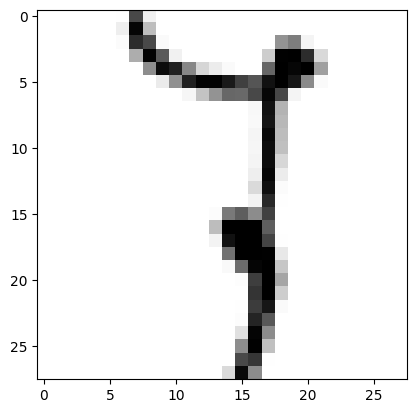

In [ ]:
plt.imshow(train_dataset[123][0].numpy().squeeze(), cmap='gray_r')

In [ ]:
train_dataset[123][0].numpy().shape

(1, 28, 28)

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(300, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)

In [ ]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)). X shape: torch.Size([1, 6, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 6, 28, 28])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 6, 14, 14])
Layer Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1)). X shape: torch.Size([1, 12, 10, 10])
Layer ReLU(). X shape: torch.Size([1, 12, 10, 10])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 12, 5, 5])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 300])
Layer Linear(in_features=300, out_features=50, bias=True). X shape: torch.Size([1, 50])
Layer ReLU(). X shape: torch.Size([1, 50])
Layer Linear(in_features=50, out_features=10, bias=True). X shape: torch.Size([1, 10])


In [ ]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
y = model(X)
print(y.shape)

torch.Size([1, 10])


In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [ ]:
model = model.to(dev)

In [ ]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train_model(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        net.train()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr)
%time train_model(model, train, test, trainer, num_epochs)

epoch 1, loss 0.6197, train acc 0.796, test acc 0.837
epoch 2, loss 0.1911, train acc 0.942, test acc 0.882
epoch 3, loss 0.1384, train acc 0.958, test acc 0.897
epoch 4, loss 0.1086, train acc 0.967, test acc 0.915
epoch 5, loss 0.0913, train acc 0.973, test acc 0.910
epoch 6, loss 0.0772, train acc 0.977, test acc 0.921
epoch 7, loss 0.0663, train acc 0.980, test acc 0.920
epoch 8, loss 0.0602, train acc 0.981, test acc 0.926
epoch 9, loss 0.0526, train acc 0.984, test acc 0.934
epoch 10, loss 0.0465, train acc 0.985, test acc 0.931
CPU times: user 1min 33s, sys: 683 ms, total: 1min 34s
Wall time: 1min 37s


Вывод: значение функции потерь быстро уменьшается. При самом удачном запуске точность на тестовой выборке достигла 93%, что является хорошим показателем. В среднем - 91%. Можно улучшить показатели за счёт свёрточной сети

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=2),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=5, padding=2),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, padding=2),
    nn.MaxPool2d(2, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.BatchNorm1d(4608),
    nn.Linear(4608, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 10),
).to(dev)
lr, num_epochs = 0.0003, 10
trainer = torch.optim.Adam(model.parameters(), lr=lr)
%time train_model(model, train, test, trainer, num_epochs)

epoch 1, loss 0.2211, train acc 0.931, test acc 0.916
epoch 2, loss 0.0842, train acc 0.974, test acc 0.924
epoch 3, loss 0.0622, train acc 0.981, test acc 0.937
epoch 4, loss 0.0474, train acc 0.985, test acc 0.939
epoch 5, loss 0.0439, train acc 0.986, test acc 0.952
epoch 6, loss 0.0354, train acc 0.989, test acc 0.951
epoch 7, loss 0.0319, train acc 0.990, test acc 0.958
epoch 8, loss 0.0270, train acc 0.992, test acc 0.956
epoch 9, loss 0.0300, train acc 0.991, test acc 0.954
epoch 10, loss 0.0237, train acc 0.992, test acc 0.954
CPU times: user 2min 6s, sys: 671 ms, total: 2min 6s
Wall time: 2min 7s


Вывод: модель обучается более эффективно и достигает более высоких точностей на тестовой выборке. Уже с первого запуска точность >90%, а средний показатель достиг 94% примерно. Итак, высокий уровень точности достигнут

In [ ]:
y_true = []
y_pred_2 = []
for X, y in test:
  X, y = X.to(dev), y.to(dev)
  y_pred_1 = model(X)
  y_true.extend(y)
  y_pred_2.extend(y_pred_1.argmax(dim=1))

In [ ]:
y_true = [i.item() for i in y_true]
y_pred_2 = [i.item() for i in y_pred_2]

In [ ]:
conf_mx = confusion_matrix(y_true, y_pred_2, normalize="pred")

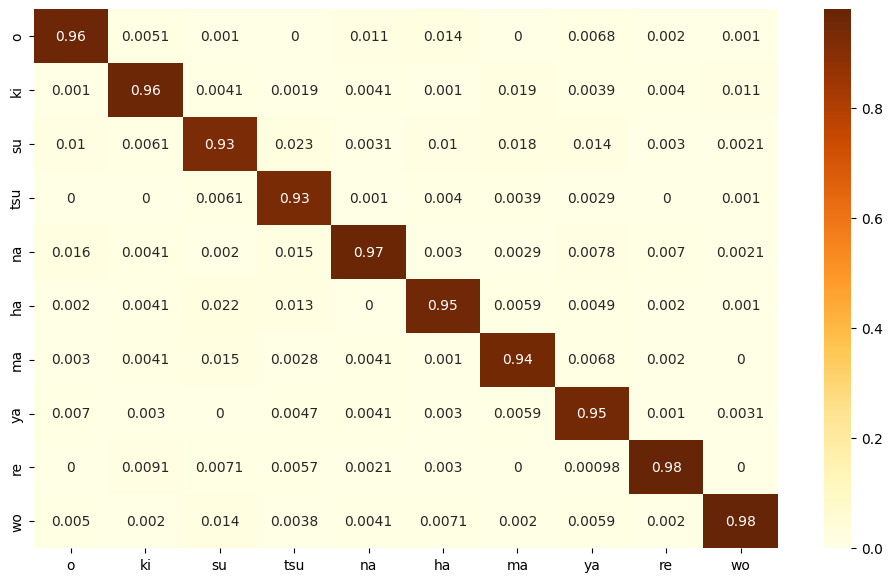

In [ ]:
df_cm = pd.DataFrame(conf_mx, index=test_dataset.class_to_idx,
                     columns=test_dataset.classes)
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, cmap="YlOrBr");

Сильной путаницы между парами иероглифов не видно. Можно только выделить o, na и ki, su, ma, которые чаще остальных модель классифицирует ошибочно. Диагональные элементы определены точно, их показатель >0,92

Попробую изменить гиперпараметры, чтобы ещё улучшить показатели

In [ ]:
BATCH_SIZE=128

In [ ]:
train_dataset = tv.datasets.KMNIST(
    root='.', train=True, transform=tv.transforms.ToTensor(), download=True
)
test_dataset = tv.datasets.KMNIST(
    root='.', train=False, transform=tv.transforms.ToTensor(), download=True
)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Flatten(),
    nn.Linear(256 * 3 * 3, 512),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(256, 10),
).to(dev)
lr, num_epochs = 0.0001, 10
trainer = torch.optim.Adam(model.parameters(), lr=lr)
%time train_model(model, train, test, trainer, num_epochs)

epoch 1, loss 0.4327, train acc 0.877, test acc 0.887
epoch 2, loss 0.1059, train acc 0.969, test acc 0.916
epoch 3, loss 0.0635, train acc 0.982, test acc 0.940
epoch 4, loss 0.0417, train acc 0.988, test acc 0.945
epoch 5, loss 0.0299, train acc 0.992, test acc 0.946
epoch 6, loss 0.0212, train acc 0.994, test acc 0.946
epoch 7, loss 0.0176, train acc 0.995, test acc 0.950
epoch 8, loss 0.0112, train acc 0.997, test acc 0.947
epoch 9, loss 0.0107, train acc 0.997, test acc 0.948
epoch 10, loss 0.0100, train acc 0.997, test acc 0.953
CPU times: user 1min 58s, sys: 417 ms, total: 1min 58s
Wall time: 1min 59s


Модель показала хорошие результата, можно отметить, что точность на тестовой выборке начиная с 3 запуска стабильно держит высокий уровень, однако по сравнению с предыдущем не увеличила среднее значение точности, что говорит о том, что выбор гиперпараметров в прошлом обучении был оптимальным.